In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [97]:
common_path = "/Users/michaelpatsais/Documents/Uni_work/machine_learning/Data/HAR_Updated"

In [98]:
df_train = pd.read_csv(common_path + "/Training.csv")
df_test = pd.read_csv(common_path + "/Testing.csv")

# extracting unique values from the "class" column of `labels_df` and converting them into a list.
labels = df_train["label"].unique().tolist()
labels = [x.strip() for x in labels]
print(labels)

# creating an array of integers from 0 to the length of the `labels` list to assign a numerical identifier to each unique label in the dataset.
classes = list(range(len(labels)))
classes = [str(x) for x in classes]
print(classes)

labels_map = dict(zip(labels, classes))
df_train["class"] = df_train["label"].map(labels_map)
df_test["class"] = df_test["label"].map(labels_map)
print(df_test)

['sitting', 'using_laptop', 'hugging', 'sleeping', 'drinking', 'clapping', 'dancing', 'cycling', 'calling', 'laughing', 'eating', 'fighting', 'listening_to_music', 'running', 'texting']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']
             filename               label class
0      Image_6301.jpg             hugging     2
1      Image_6302.jpg             hugging     2
2      Image_6303.jpg            clapping     5
3      Image_6304.jpg             dancing     6
4      Image_6305.jpg            drinking     4
...               ...                 ...   ...
6295  Image_12596.jpg             sitting     0
6296  Image_12597.jpg            clapping     5
6297  Image_12598.jpg             sitting     0
6298  Image_12599.jpg             dancing     6
6299  Image_12600.jpg  listening_to_music    12

[6300 rows x 3 columns]


In [ ]:
#  need to label test data or split training images/csv into training & test

In [99]:
# PREPROCESSING - LOADING DATA

idg = ImageDataGenerator(rescale = 1./255.)

train, val = train_test_split(df_train.drop("label", axis = 1), test_size=0.5)

# train
train_ds = idg.flow_from_dataframe(dataframe = train, directory = common_path + "/train", classes = classes, batch_size = 100)

# validation
val_ds = idg.flow_from_dataframe(dataframe = val, directory = common_path + "/train", classes = classes, batch_size = 100)

# test
test_ds = idg.flow_from_dataframe(dataframe = df_test.drop("label", axis = 1), directory = common_path + "/test", classes = classes, batch_size = 100)


Found 1850 validated image filenames belonging to 15 classes.
Found 1848 validated image filenames belonging to 15 classes.
Found 3699 validated image filenames belonging to 15 classes.


/Users/michaelpatsais/Documents/Uni_work/machine_learning/mlvenv/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1300 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/Users/michaelpatsais/Documents/Uni_work/machine_learning/mlvenv/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1302 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/Users/michaelpatsais/Documents/Uni_work/machine_learning/mlvenv/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2601 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [100]:
#  MODEL CONFIGURATION
epochs = 2
dropout_val = 0.4

# image dimentions
xpix = train_ds[0][0][0].shape[0]
ypix = train_ds[0][0][0].shape[1]
zpix = train_ds[0][0][0].shape[2]

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(xpix, ypix, zpix)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(dropout_val),
    tf.keras.layers.Dense(32, activation='relu'),
    
    tf.keras.layers.Dense(15, activation='softmax')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 252, 252, 64)      4864      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 126, 126, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 32)      18464     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 123008)            0         
                                                                 
 dense_18 (Dense)            (None, 32)               

In [101]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [102]:
history  = model.fit(train_ds, validation_data = val_ds, epochs=epochs)

Epoch 1/2
19/19 [==============================] - 74s 4s/step - loss: 2.9177 - accuracy: 0.0681 - val_loss: 2.7061 - val_accuracy: 0.0611
Epoch 2/2
19/19 [==============================] - 71s 4s/step - loss: 2.7082 - accuracy: 0.0741 - val_loss: 2.7066 - val_accuracy: 0.0763


In [103]:
predictions = model.predict(test_ds)

37/37 [==============================] - 25s 663ms/step


In [104]:
# combining batches so that test and prediction images line up
all_images = np.concatenate([test_ds[batch][0] for batch in range(len(test_ds))])
all_images_data = np.concatenate([test_ds[batch][1] for batch in range(len(test_ds))])

print(all_images.shape)


(3699, 256, 256, 3)


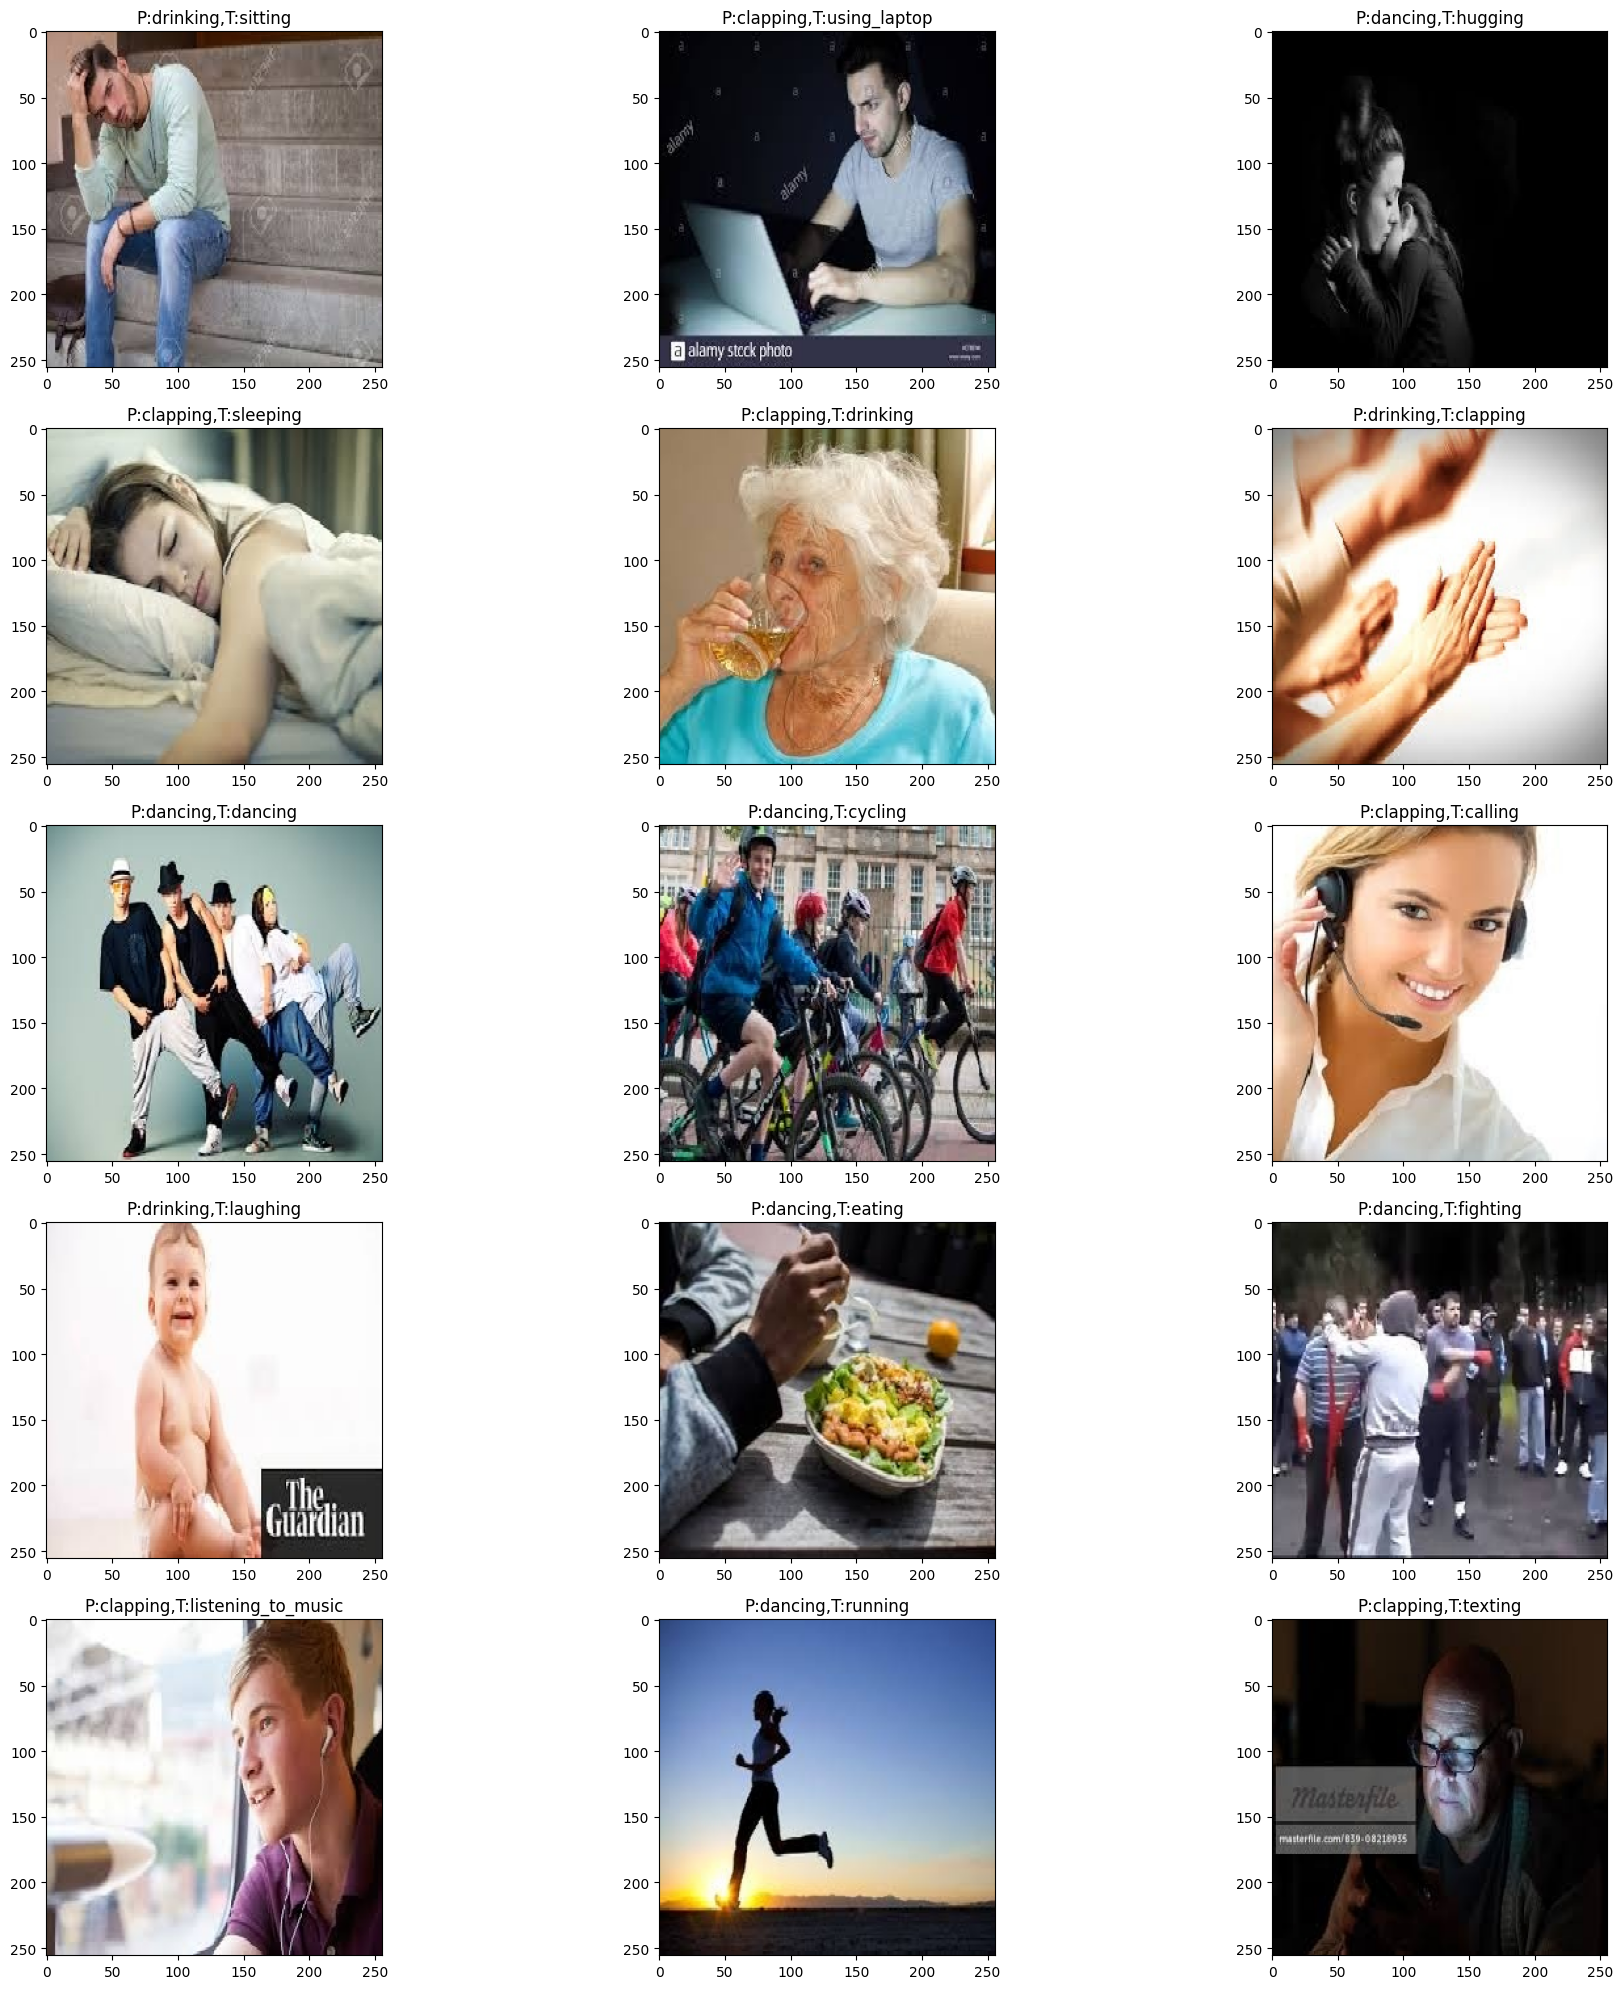

[(4, 0, 'sitting'), (5, 1, 'using_laptop'), (6, 2, 'hugging'), (5, 3, 'sleeping'), (5, 4, 'drinking'), (4, 5, 'clapping'), (6, 6, 'dancing'), (6, 7, 'cycling'), (5, 8, 'calling'), (4, 9, 'laughing'), (6, 10, 'eating'), (6, 11, 'fighting'), (5, 12, 'listening_to_music'), (6, 13, 'running'), (5, 14, 'texting')]


In [105]:
fig, axes = plt.subplots(5, 3, figsize = (20,20))
store = []
for i in range(15): # a counter that represents the classfication we want to print
    ax = axes[i//3, i%3] # calculating the subplot to print to
    for image in range(len(all_images_data)):
        if (np.argmax(all_images_data[image]) != i): # if the image is not of the right classification, it is skipped
            continue
        else:
            store.append((np.argmax(predictions[image]), i, labels[i]))
            ax.set_title(f"P:{labels[np.argmax(predictions[image])]},T:{labels[i]}") # right classification is printed, with its label and corresponding prediction
            ax.imshow(all_images[image])
            break # break to move on to next classification
        
plt.tight_layout()
# plt.savefig(save_directory + "/2b.png")
plt.show()
print(store)